In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow_addons.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
from focal_loss import BinaryFocalLoss

In [43]:
def history_plot(*args, metric='loss'):
    if len(args) > 1:
        sum_list = []
        for x in args:
            sum_list += x.history[metric]
        val_sum_list = []
        for x in args:
            val_sum_list += x.history['val_' + metric]
        plt.plot(sum_list)
        plt.plot(val_sum_list)
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    else:
        history = args[0]
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [3]:
def to_one_hot(x):
    return label_binarize(x, classes=range(149)).flatten()

In [4]:
champion_index = list(pd.read_csv('processed_data/chamion_index.csv', index_col=0).values.flatten())

champion_dict = {y:i for i,y in enumerate(champion_index)}

df = pd.read_csv('processed_data/esports_data.csv')

df.champions = df.champions.apply(lambda x: ast.literal_eval(x))

df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])

df = df.drop_duplicates(subset=['team', 'id', 'win']).copy()

In [5]:
df = pd.merge(df[df.team == 'Blue'], df[df.team == 'Red'], on='id', suffixes=('_blue', '_red'))

In [12]:
X = np.zeros(shape=(len(df),2,745))
for i,comp in enumerate(df.champion_ids_blue):
    X[i,0,:] = to_one_hot(comp)
for i,comp in enumerate(df.champion_ids_red):
    X[i,1,:] = to_one_hot(comp)
y = df.win_blue.values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

In [16]:
blue_pre = tf.keras.models.load_model('saved_models/CBoW_focal_loss_w_esports_9000', compile=False).layers[0]
red_pre = tf.keras.models.load_model('saved_models/CBoW_focal_loss_w_esports_9000', compile=False).layers[0]

blue_pre.trainable = False
blue_pre._name = 'blue_pre'
red_pre.trainable = False
red_pre._name = 'red_pre'

In [17]:
blue_pre.trainable = False
blue_pre._name = 'blue_pre'
red_pre.trainable = False
red_pre._name = 'red_pre'

In [18]:
b_in = tf.keras.layers.Input(shape=(745,), name='blue_input')
b_pre_dim_red = blue_pre(b_in)

r_in = tf.keras.layers.Input(shape=(745,), name='red_input')
r_pre_dim_red = red_pre(r_in)

x = tf.keras.layers.concatenate([b_pre_dim_red, r_pre_dim_red])
combined = tf.keras.layers.Dense(32, activation='relu', name='dense_32')(x)
combined = tf.keras.layers.Dense(16, activation='relu', name='dense_16')(combined)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='blue_win_output')(combined)

In [33]:
model = tf.keras.Model(inputs=[b_in, r_in], outputs=output)

In [34]:
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics='accuracy')

In [35]:
tqdm_callback = TQDMProgressBar(show_epoch_progress=False)

In [37]:
model.evaluate((X_test[:,0,:], X_test[:,1,:]), y_test)

15/15 [==============================] - 0s 1ms/step - loss: 0.7068 - accuracy: 0.4582


[0.7067733407020569, 0.45824411511421204]

In [46]:
history3 = model.fit((X_train[:,0,:], X_train[:,1,:]), y_train,
                    epochs=10000,
                    batch_size=32,
                    shuffle=True,
                    verbose=0,
                    validation_data=((X_test[:,0,:], X_test[:,1,:]), y_test),
                    callbacks=[tqdm_callback])

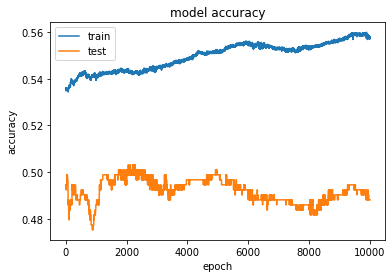

In [47]:
history_plot(history3, metric='accuracy')

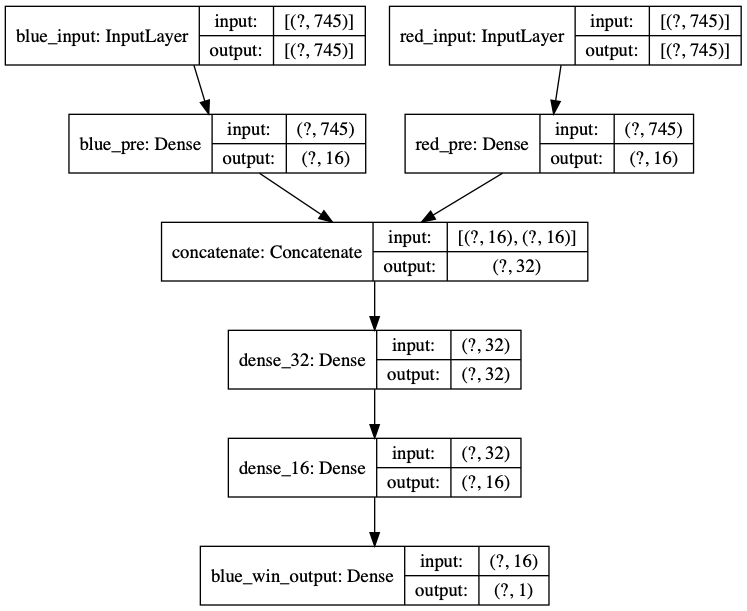

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)